In [93]:
%matplotlib inline
import numpy as np 
import torch
import torch.optim as optim

torch.set_printoptions(edgeitems=2, linewidth=75)

#### Preprocess the data

In [94]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) # <1>
t_u = torch.tensor(t_u).unsqueeze(1) # <1>
print(t_u.dtype, t_c.dtype)
t_u.shape

torch.float32 torch.float32


torch.Size([11, 1])

In [95]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([ 1,  0,  9,  2,  6, 10,  8,  7,  5]), tensor([3, 4]))

In [96]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

#### Create and train the NN

In [97]:
import torch.nn as nn

linear_model = nn.Linear(1, 1)
linear_model(t_un_val)

tensor([[0.4547],
        [0.0553]], grad_fn=<AddmmBackward0>)

In [98]:
linear_model.weight

Parameter containing:
tensor([[0.1560]], requires_grad=True)

In [99]:
linear_model.bias

Parameter containing:
tensor([-0.8230], requires_grad=True)

In [100]:
x = torch.ones(1)
linear_model(x)

tensor([-0.6670], grad_fn=<AddBackward0>)

In [101]:
x = torch.ones(10, 1)
linear_model(x)

tensor([[-0.6670],
        [-0.6670],
        [-0.6670],
        [-0.6670],
        [-0.6670],
        [-0.6670],
        [-0.6670],
        [-0.6670],
        [-0.6670],
        [-0.6670]], grad_fn=<AddmmBackward0>)

In [102]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

In [103]:
linear_model.parameters()

<generator object Module.parameters at 0x000001D5F4A8FDD0>

In [104]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[-0.5532]], requires_grad=True),
 Parameter containing:
 tensor([-0.4070], requires_grad=True)]

In [105]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val, t_c_train, t_c_val):
    for epoch in range(1, n_epochs+1):
        t_p_train = model(t_u_train)
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val)
        loss_val = loss_fn(t_p_val, t_c_val)

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")

In [106]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

linear_model = nn.Linear(1, 1) # <1>
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = loss_fn,
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 218.9772, Validation loss 687.8569
Epoch 1000, Training loss 3.8983, Validation loss 8.7504
Epoch 2000, Training loss 2.9580, Validation loss 4.1999
Epoch 3000, Training loss 2.9134, Validation loss 3.5544

Parameter containing:
tensor([[5.1685]], requires_grad=True)
Parameter containing:
tensor([-16.2730], requires_grad=True)


In [107]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = nn.MSELoss(), # <1>
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 155.7759, Validation loss 536.5394
Epoch 1000, Training loss 4.0689, Validation loss 9.3863
Epoch 2000, Training loss 2.9661, Validation loss 4.2757
Epoch 3000, Training loss 2.9138, Validation loss 3.5679

Parameter containing:
tensor([[5.1658]], requires_grad=True)
Parameter containing:
tensor([-16.2591], requires_grad=True)


In [108]:
seq_model = nn.Sequential(
            nn.Linear(1, 13), # <1>
            nn.Tanh(),
            nn.Linear(13, 1)) # <2>
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [109]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

In [110]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [111]:
from collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, 8)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(8, 1))
]))

seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [112]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


In [113]:
seq_model.output_linear.bias

Parameter containing:
tensor([-0.0470], requires_grad=True)

In [114]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3) # <1>

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)
    
print('output', seq_model(t_un_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1, Training loss 135.2442, Validation loss 468.5164
Epoch 1000, Training loss 4.4961, Validation loss 47.8379
Epoch 2000, Training loss 2.7705, Validation loss 25.1121
Epoch 3000, Training loss 2.3435, Validation loss 17.1258
Epoch 4000, Training loss 2.1862, Validation loss 12.9295
Epoch 5000, Training loss 2.1174, Validation loss 10.5301
output tensor([[23.7340],
        [12.6905]], grad_fn=<AddmmBackward0>)
answer tensor([[28.],
        [11.]])
hidden tensor([[-0.0180],
        [ 0.0096],
        [ 0.0047],
        [ 0.0111],
        [ 0.0144],
        [ 0.0154],
        [ 0.0119],
        [-0.0037]])


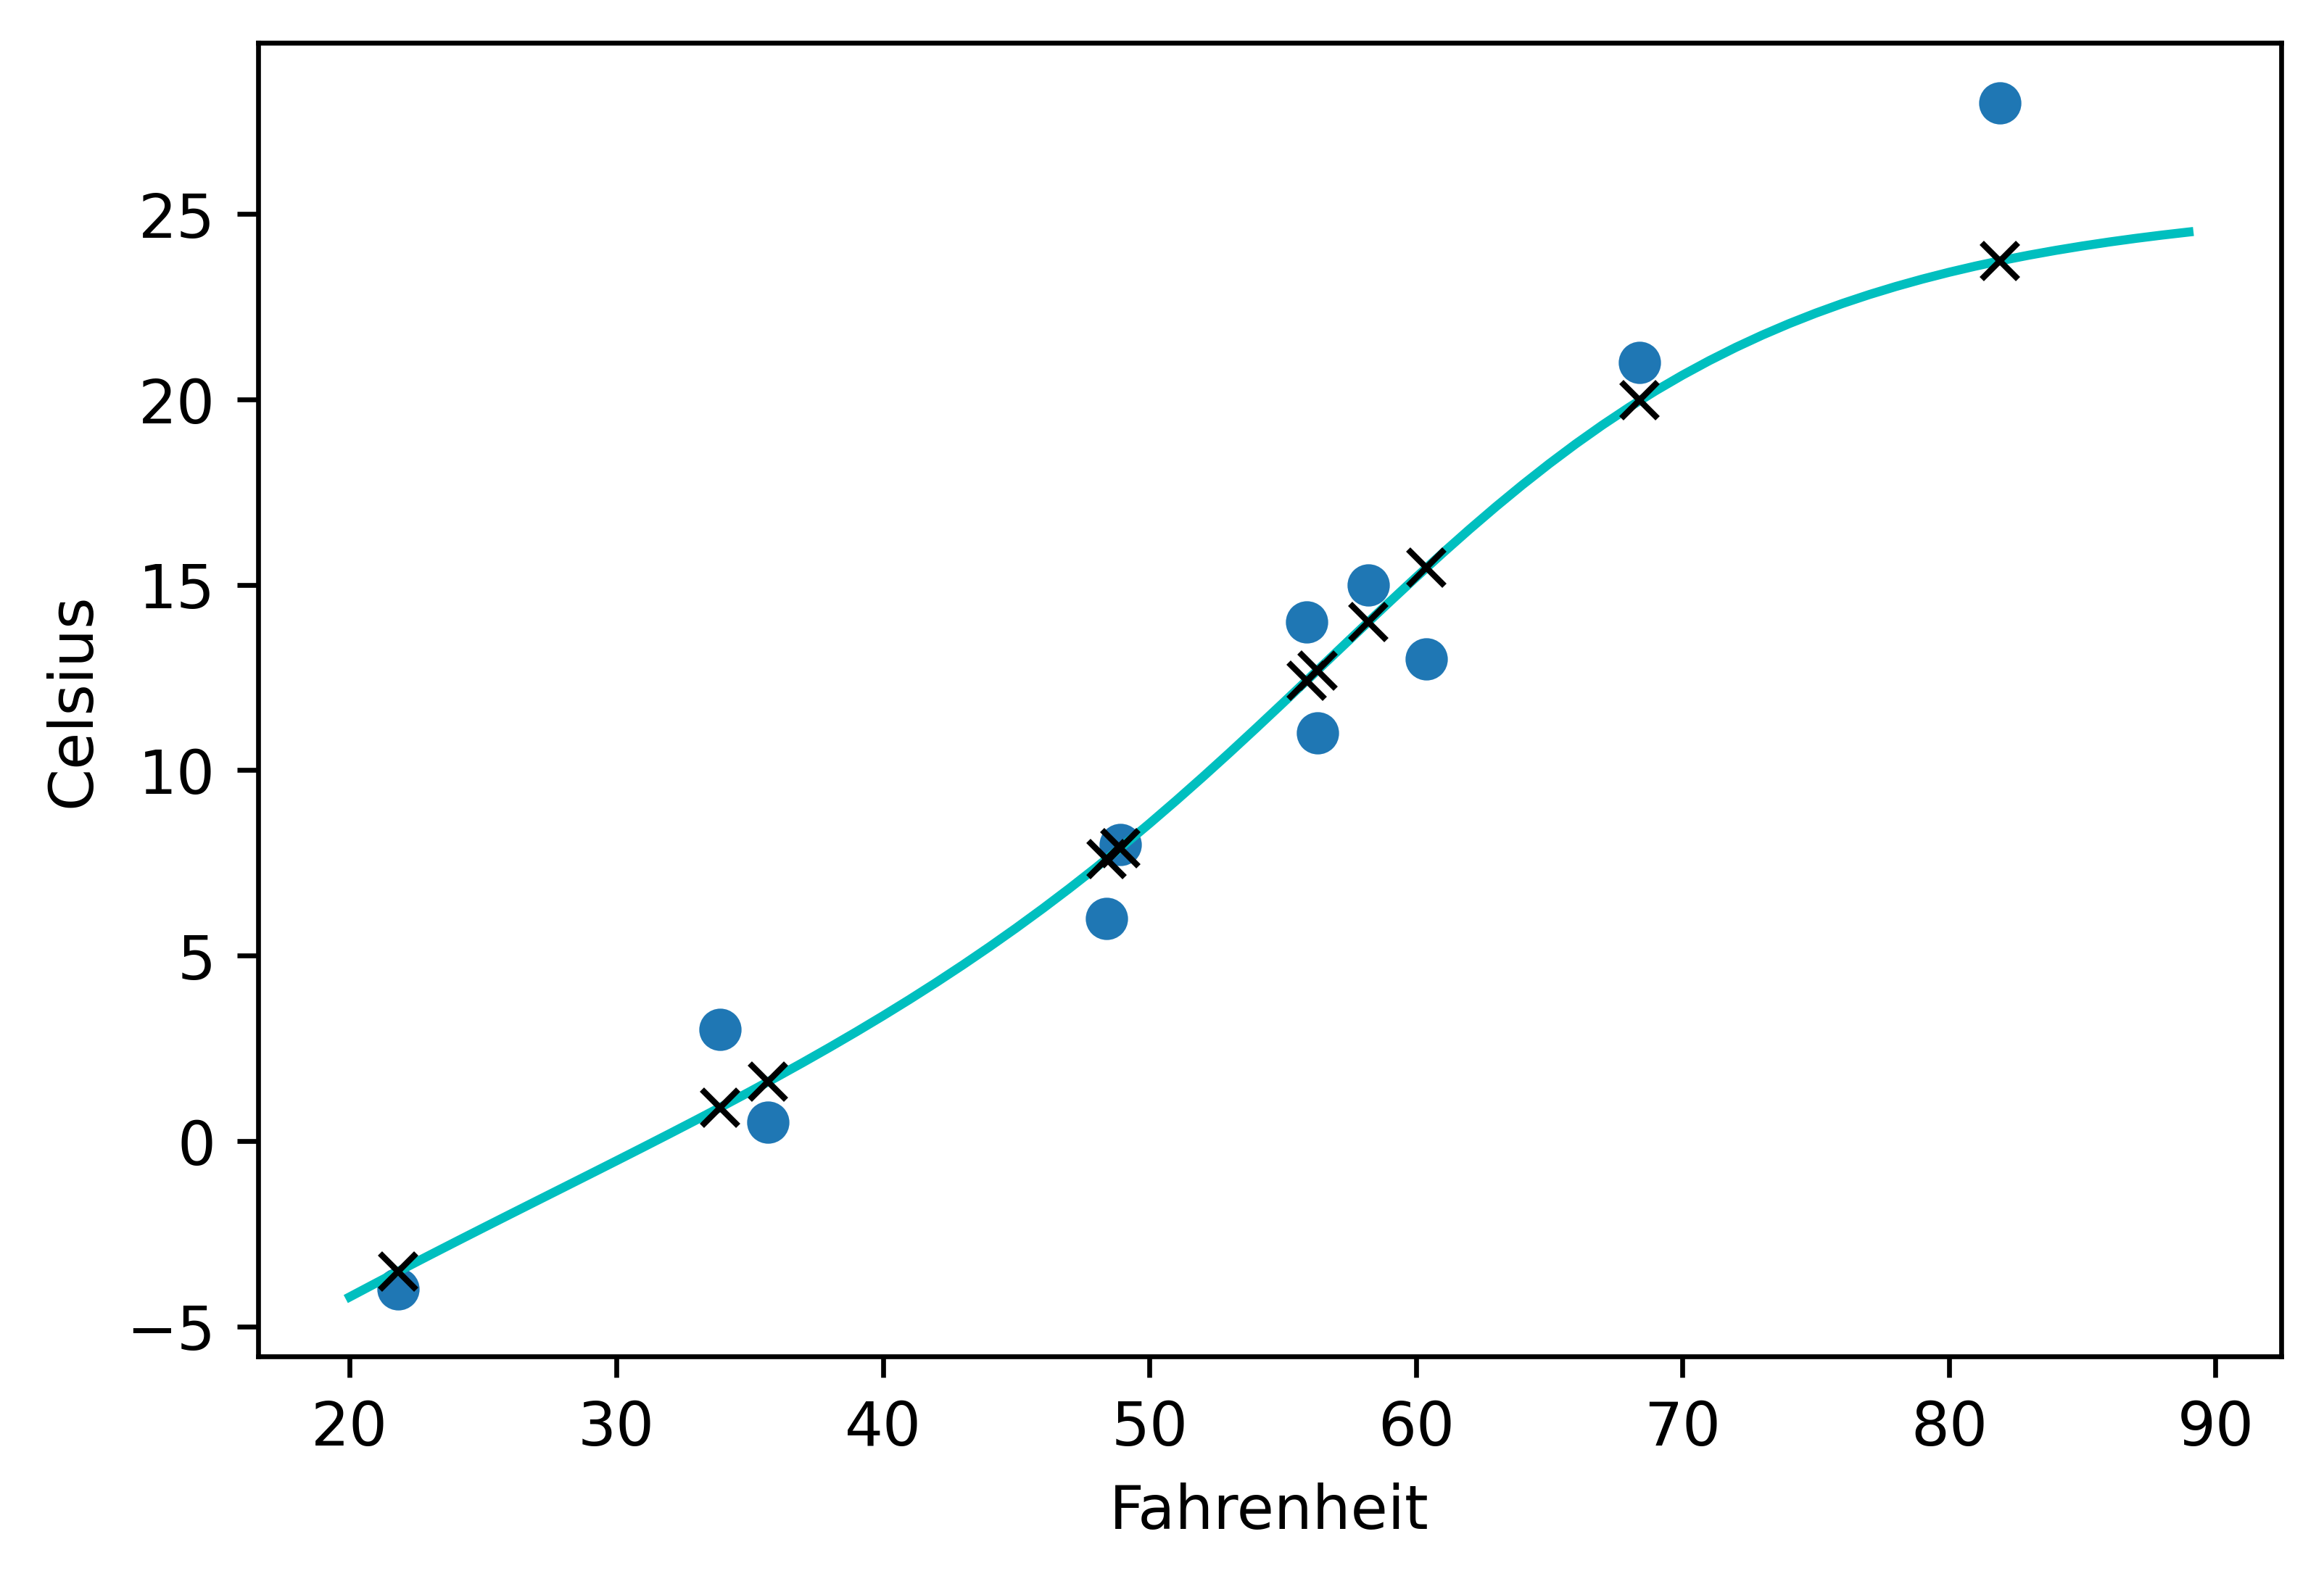

In [115]:
from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')